# Sampling period and rate

The basic scheme for digitizing an analog signal is to measure the signal $x(t)$ at a sequence of uniformly spaced time points.
The **sampling period** is denoted by $t_s$, which must be a positive number, measuring the number of seconds between samples.
(Fractional values are allowed.)
The resulting sequence of samples will be 

$$
x(0), x(0 + t_s), x(0 + t_s + t_s), \dots
$$

More generally, the $n^\text{th}$ sample (for an arbitrary integer $n = 0, 1, 2, \dots$) represents the signal at time $n\cdot t_s$.
In a slight abuse of notation, we use square brackets with index $n$ to indicate discrete signals $x[n]$, and parentheses with time $t$ to denote continuous signals:

$$
x[n] = x(n \cdot t_s).
$$

By convention, we use $N$ to denote the total number of samples.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

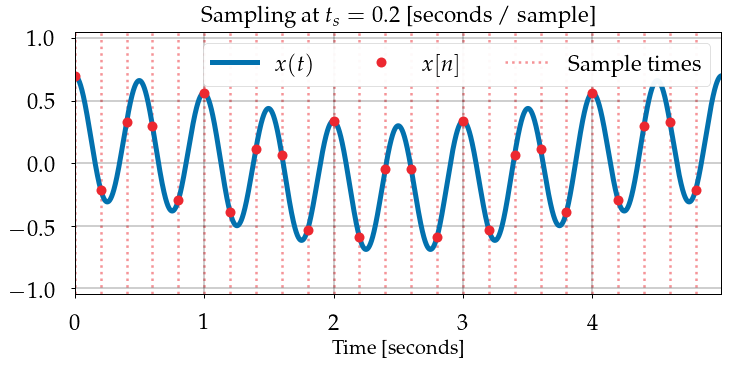

In [5]:
fs = 1000
duration = 5
t = np.linspace(0, duration, num=duration * fs, endpoint=False)

x = 0.5 * np.cos(2 * np.pi * 2 * t) + 0.2 * np.cos(2 * np.pi * 0.2 * t)

ts = 200

fig, ax = plt.subplots(figsize=figaspect(0.5))

ax.plot(t, x, label=r'$x(t)$')
ax.plot(t[::ts], x[::ts], linestyle='', marker='.', label=r'$x[n]$')
ax.vlines(t[::ts], -2, 2, color=colors[1], alpha=0.5, linestyle=':', zorder=-3, linewidth=2, label='Sample times')
ax.legend(loc='upper right', ncol=3)
ax.set(ylim=[-1.05, 1.05],
        title='Sampling at $t_s={}$ [seconds / sample]'.format(ts / fs),
        xlabel='Time [seconds]');

Oftentimes, it is more convenient to work with the **sampling rate**, which we denote as

$$
f_s = \frac{1}{t_s} \quad \left[\frac{\text{samples}}{\text{second}}\right].
$$

Note that the sampling rate can always be converted to a sampling period (and vice versa) by taking reciprocals,
resulting in the following (equivalent) form for discretely sampled signals:

$$
x[n] = x\left(\frac{n}{f_s}\right).
$$

## Example: tone generation

We now have everything that we need to start making sounds.  In this example, we'll generate a pure tone at 220 Hz.

Recall from the previous chapter that a wave at frequency $f_0$ is expressed as a function of time $t$ by

$$
x(t) = \cos\left(2\pi \cdot f_0 \cdot t\right).
$$

(Here, we'll ignore amplitude and phase to keep things simple.)

Even if we don't have an existing signal to sample, we can still sample from this idealized signal by subtituting $t = n / f_s$ and computing the cosine values directly:

$$
x[n] = \cos\left(2\pi \cdot f_0 \cdot \frac{n}{f_s}\right),
$$

or, in code:
```python
for n in range(N):  # n goes from 0, 1, 2, ..., N-1
    x[n] = np.cos(2 * np.pi * f_0 * n / f_s)
```

### Vectorization
In practice, generating a tone in this fashion would be rather slow -- at least, when using the Python programming language.
Instead, a much faster way to do it is to pre-allocate all the values of `n` as a *vector* 
```
n = [0, 1, 2, ..., N-1].
```
In code, you can do this by using the `np.arange` function, like so:
```python
n = np.arange(N)  # n is now an array containing values [0, 1, 2, ..., N-1]
x = np.cos(2 * np.pi * f_0 * n / f_s)
```
The result will be an array `x` with `N` total samples.
Python (numpy) is smart enough to know that when you multiply, add, and call cosine on lists of numbers, it should apply these operations to each element of the list.
This process is called *vectorization*, and it's quite common in numerical computing.
It might look a little strange and take some getting used to, but it does simplify and accelerate many of the types of operations we do in signal processing code.

```{margin}
**Note:** For our purposes here, the word *vector* just means a list or array of numbers.
```

In [4]:
# We use numpy for numeric computation
import numpy as np

# The Audio object allows us to play back sound
# directly in the web browser
from IPython.display import Audio


# We'll use an 8 KHz sampling rate, roughly
# equivalent to telephone quality
fs = 8000

# And generate 1.5 seconds of audio
duration = 1.5

# Total number of samples
# we round it down to a whole number by int(...)
N = int(duration * fs)

# Generate a pure tone at 220 Hz
f0 = 220

# Make an array of sample indices
n = np.arange(N)

# And make the tone, using (n / fs) in place of t
x = np.cos(2 * np.pi * f0 * n / fs)

# How's it sound?
Audio(data=x, rate=fs)